In [21]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from datasets import DatasetDict, concatenate_datasets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
dataset = load_dataset("jackhhao/jailbreak-classification")
# rename prompt to text and label to label
dataset = dataset.rename_column("prompt", "text")
dataset = dataset.rename_column("type", "labels")

def label_mapping(example):
    example["labels"] = 0 if example["labels"] == "benign" else 1
    return example

dataset = dataset.map(label_mapping)


In [3]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from datasets import DatasetDict

# Split the training set into 80% train and 20% validation
# shuffle train 

from sklearn.model_selection import train_test_split

train_test_split = tokenized_datasets['train'].train_test_split(test_size=0.2, stratify_by_column='label', random_state=42)

# Combine the new splits into a DatasetDict
final_dataset = DatasetDict({
    'train': train_test_split['train'],
    'val': train_test_split['test'],
    'test': tokenized_datasets['test']
})

In [5]:
# i take this params from : https://huggingface.co/jackhhao/jailbreak-classifier
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5, # need to be changed to 5
    lr_scheduler_type="linear",
   # logging_dir="./logs",
    save_strategy="no",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["val"],

)
trainer.train()
trainer.evaluate()

/opt/anaconda3/envs/qualifier-env/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                                 
 20%|██        | 105/525 [02:33<09:16,  1.33s/it]

{'eval_loss': 0.13324245810508728, 'eval_runtime': 10.6331, 'eval_samples_per_second': 19.656, 'eval_steps_per_second': 2.539, 'epoch': 1.0}


                                                 
 40%|████      | 210/525 [05:30<06:21,  1.21s/it]

{'eval_loss': 0.07492302358150482, 'eval_runtime': 10.1002, 'eval_samples_per_second': 20.693, 'eval_steps_per_second': 2.673, 'epoch': 2.0}


                                                 
 60%|██████    | 315/525 [08:17<03:57,  1.13s/it]

{'eval_loss': 0.08100993931293488, 'eval_runtime': 9.2755, 'eval_samples_per_second': 22.532, 'eval_steps_per_second': 2.911, 'epoch': 3.0}


                                                 
 80%|████████  | 420/525 [11:06<02:20,  1.34s/it]

{'eval_loss': 0.12457344681024551, 'eval_runtime': 11.1269, 'eval_samples_per_second': 18.783, 'eval_steps_per_second': 2.427, 'epoch': 4.0}


 95%|█████████▌| 500/525 [12:53<00:33,  1.34s/it]

{'loss': 0.0611, 'grad_norm': 0.004706718493252993, 'learning_rate': 2.3809523809523808e-06, 'epoch': 4.76}


                                                 
100%|██████████| 525/525 [13:36<00:00,  1.55s/it]


{'eval_loss': 0.11419247090816498, 'eval_runtime': 9.2678, 'eval_samples_per_second': 22.551, 'eval_steps_per_second': 2.913, 'epoch': 5.0}
{'train_runtime': 816.2722, 'train_samples_per_second': 5.115, 'train_steps_per_second': 0.643, 'train_loss': 0.05821872117441325, 'epoch': 5.0}


100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


{'eval_loss': 0.11419247090816498,
 'eval_runtime': 9.2564,
 'eval_samples_per_second': 22.579,
 'eval_steps_per_second': 2.917,
 'epoch': 5.0}

In [13]:
trained_model = trainer.model

In [14]:
# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the model to the MPS device
trained_model.to(device)

# Ensure model is in evaluation mode
trained_model.eval()

# Prepare the test dataset (tokenized inputs and attention mask)
X_test = tokenized_datasets["test"]["input_ids"]
attention_mask = tokenized_datasets["test"]["attention_mask"]

# Convert input IDs and attention mask to tensors and move to device
input_ids_tensor = torch.tensor(X_test).to(device)
attention_mask_tensor = torch.tensor(attention_mask).to(device)

# Make predictions
with torch.no_grad():  # Disable gradient calculation for predictions
    outputs = trained_model(input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # Get the logits from the output

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted class indices
y_pred = probabilities.argmax(dim=1)

# Get confidence scores (max probabilities)
confidence_scores = probabilities.max(dim=1).values
y_test = tokenized_datasets["test"]["labels"]


In [15]:
y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)

# Move y_pred to CPU and convert to NumPy
y_pred_cpu = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else np.array(y_pred)

# Calculate metrics
_f1_score = f1_score(y_test, y_pred_cpu)
_accuracy = accuracy_score(y_test, y_pred_cpu)
_recall = recall_score(y_test, y_pred_cpu)
_precision = precision_score(y_test, y_pred_cpu)

# Print results
print(f"F1 Score: {_f1_score:.4f}")
print(f"Accuracy: {_accuracy:.4f}")
print(f"Recall: {_recall:.4f}")
print(f"Precision: {_precision:.4f}")

F1 Score: 0.9964
Accuracy: 0.9962
Recall: 0.9928
Precision: 1.0000


In [8]:
tokenized_datasets["train"].features["labels"]

Value(dtype='int64', id=None)

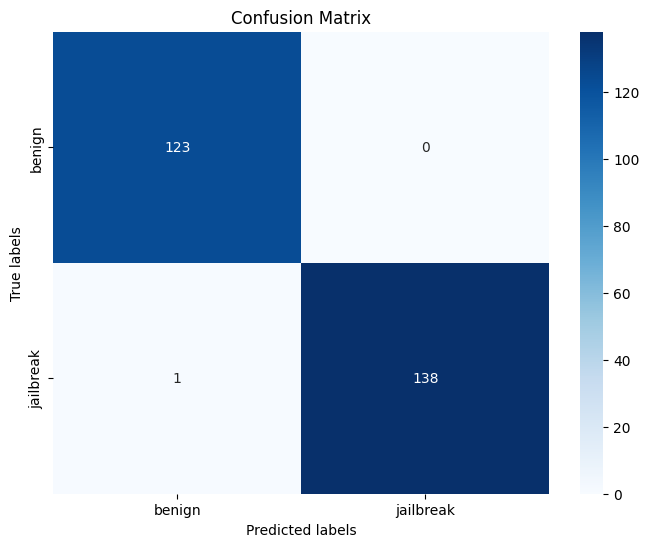

In [16]:


def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred_cpu, labels=['benign', 'jailbreak'])


#### now before upload to inference i want concat the train and val to train again and trained the model on train + val and evaluate on test and because the result are very good we set down the epochs to 3 and the learning rate to 1e-5


In [22]:

# Assuming final_dataset["train"] and final_dataset["val"] are your train and validation datasets
train_val_dataset = concatenate_datasets([final_dataset["train"], final_dataset["val"]])

# Create the final DatasetDict
final_dataset_2 = DatasetDict({
    'train': train_val_dataset,
    'test': tokenized_datasets['test']
})

In [25]:


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3, 
    lr_scheduler_type="linear",
   # logging_dir="./logs",
    save_strategy="no",
)

trainer_2 = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=final_dataset_2["train"],
    eval_dataset=final_dataset_2["test"],

)
trainer_2.train()
trainer_2.evaluate()

/opt/anaconda3/envs/qualifier-env/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(

































                                                

                                         
  3%|▎         | 13/393 [03:46<08:38,  1.36s/it] 



{'eval_loss': 0.0426008515059948, 'eval_runtime': 11.826, 'eval_samples_per_second': 22.155, 'eval_steps_per_second': 2.79, 'epoch': 1.0}



































                                                

                                         
  3%|▎         | 13/393 [06:55<08:38,  1.36s/it] 



{'eval_loss': 0.12218038737773895, 'eval_runtime': 11.7376, 'eval_samples_per_second': 22.321, 'eval_steps_per_second': 2.811, 'epoch': 2.0}



































                                                

                                         
  3%|▎         | 13/393 [10:03<08:38,  1.36s/it] 

                                                
100%|██████████| 393/393 [09:25<00:00,  1.44s/it]


{'eval_loss': 0.11690198630094528, 'eval_runtime': 11.7168, 'eval_samples_per_second': 22.361, 'eval_steps_per_second': 2.816, 'epoch': 3.0}
{'train_runtime': 565.9224, 'train_samples_per_second': 5.534, 'train_steps_per_second': 0.694, 'train_loss': 0.02074138262799678, 'epoch': 3.0}


100%|██████████| 33/33 [00:11<00:00,  2.84it/s]


{'eval_loss': 0.11690198630094528,
 'eval_runtime': 11.691,
 'eval_samples_per_second': 22.41,
 'eval_steps_per_second': 2.823,
 'epoch': 3.0}

In [26]:
trained_model_2 = trainer_2.model
# Move the model to the MPS device
trained_model_2.to(device)

# Ensure model is in evaluation mode
trained_model_2.eval()


# Make predictions
with torch.no_grad():  # Disable gradient calculation for predictions
    outputs = trained_model_2(input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # Get the logits from the output

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted class indices
y_pred = probabilities.argmax(dim=1)

# Get confidence scores (max probabilities)
confidence_scores = probabilities.max(dim=1).values

In [27]:
# Move y_pred to CPU and convert to NumPy
y_pred_cpu = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else np.array(y_pred)

# Calculate metrics
_f1_score = f1_score(y_test, y_pred_cpu)
_accuracy = accuracy_score(y_test, y_pred_cpu)
_recall = recall_score(y_test, y_pred_cpu)
_precision = precision_score(y_test, y_pred_cpu)

# Print results
print(f"F1 Score: {_f1_score:.4f}")
print(f"Accuracy: {_accuracy:.4f}")
print(f"Recall: {_recall:.4f}")
print(f"Precision: {_precision:.4f}")

F1 Score: 0.9854
Accuracy: 0.9847
Recall: 0.9712
Precision: 1.0000


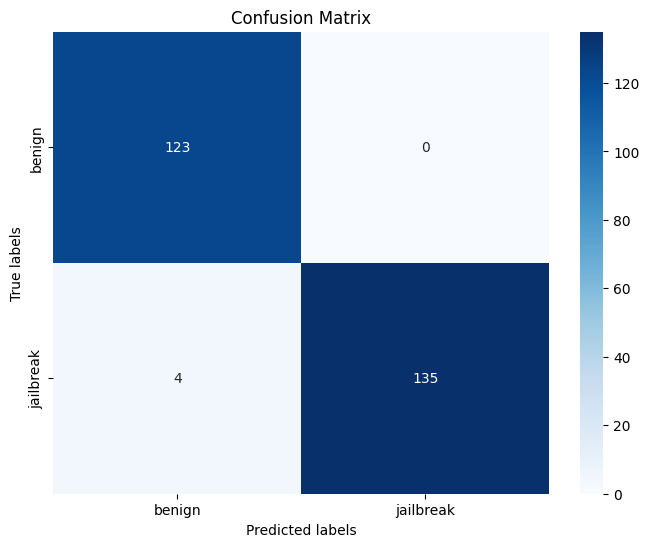

In [28]:
plot_confusion_matrix(y_test, y_pred_cpu, labels=['benign', 'jailbreak'])


In [29]:

trained_model_2.config.id2label = {
    "0": "benign",
    "1": "jailbreak"
}

In [30]:
load_dotenv()
if 'HF_TOKEN' in os.environ:
    print("pushing to huggingface hub")
    HF_TOKEN = os.getenv("HF_TOKEN")
    login(token=HF_TOKEN)  
    trained_model_2.push_to_hub("oranne55/qualifier-model3-finetune-pretrained-transformer")
    tokenizer.push_to_hub("oranne55/qualifier-model3-finetune-pretrained-transformer")

pushing to huggingface hub


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
model.safetensors: 100%|██████████| 438M/438M [00:44<00:00, 9.79MB/s]
No files have been modified since last commit. Skipping to prevent empty commit.
